In [5]:
import numpy as np
import pandas as pd
# === Set the shared path and load data set ===
base_path = r'G:\LA5c project\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [6]:
df_combined

,Subject_ID,Rest_cingulum_ant_mid_pos_to_Middle_frontal_R_L,Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L,Rest_cingulum_ant_mid_pos_to_Precentral_MFG_R_L,Rest_cingulum_ant_mid_pos_to_precuneus_R_L,Rest_cingulum_ant_mid_pos_to_SMA_R_L,Rest_Middle_frontal_R_L_to_occipital_sup_R_L,Rest_Middle_frontal_R_L_to_Precentral_MFG_R_L,Rest_Middle_frontal_R_L_to_precuneus_R_L,Rest_Middle_frontal_R_L_to_SMA_R_L,...,SST_Stop_Middle_frontal_R_L_to_Precentral_MFG_R_L,SST_Stop_Middle_frontal_R_L_to_precuneus_R_L,SST_Stop_Middle_frontal_R_L_to_SMA_R_L,SST_Stop_occipital_sup_R_L_to_Precentral_MFG_R_L,SST_Stop_occipital_sup_R_L_to_precuneus_R_L,SST_Stop_occipital_sup_R_L_to_SMA_R_L,SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L,SST_Stop_Precentral_MFG_R_L_to_SMA_R_L,SST_Stop_precuneus_R_L_to_SMA_R_L,Label
0,1,0.014834,-0.336479,-0.027677,0.095930,0.310541,0.124793,1.091338,-0.033260,-0.095316,...,1.170319,0.049062,-0.059655,0.214845,0.125462,-0.699487,-0.089129,0.276727,-0.268441,0
1,2,0.224328,-0.207740,0.105979,0.182406,0.402633,-0.193574,0.856011,0.166000,0.032188,...,0.691951,0.023209,-0.150087,-0.154228,0.228777,0.127418,0.228602,0.198429,0.043162,0
2,3,-0.096183,-0.234593,-0.196171,0.192215,0.224086,-0.007425,0.861975,-0.141263,0.214659,...,1.750895,-0.313144,0.298938,0.407614,-0.014526,0.317849,-0.231258,0.476005,0.103781,0
3,4,0.197552,-0.102718,0.098043,0.307917,0.196048,-0.212539,0.891392,-0.098651,0.204031,...,1.038488,0.097237,0.045666,-0.069983,0.414711,-0.083123,0.237377,0.517069,0.119239,0
4,5,0.041581,-0.205092,-0.171112,0.617818,-0.032995,0.241889,1.020725,0.386042,-0.160685,...,1.256165,-0.291213,-0.104330,-0.368432,0.362466,-0.289908,-0.247124,0.047685,-0.010366,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,156,-0.132621,0.041915,-0.118894,0.607427,0.560431,-0.356621,0.585778,0.047665,0.004686,...,1.040887,0.040224,0.001614,-0.071233,0.370208,0.147611,0.161768,0.234150,0.054106,1
155,157,0.501687,-0.289930,0.535604,0.260251,0.485207,-0.287684,0.934090,-0.098125,-0.081556,...,0.845994,0.385361,0.065515,-0.114279,0.346778,-0.650258,0.261212,0.100699,-0.123267,1
156,158,-0.188199,0.011242,-0.338717,0.774863,-0.030647,-0.097283,0.918836,-0.495309,0.398717,...,0.672520,-0.141858,0.094832,-0.036388,0.967661,0.477574,-0.139282,0.791231,0.233730,1
157,159,0.347450,0.344471,0.355325,0.513944,0.288045,-0.049004,0.696972,0.139121,-0.100987,...,1.442530,-0.157062,0.043661,0.467717,0.091598,-0.223018,-0.243902,0.351754,-0.200664,1


# XGBoost withoutneasted cv 


In [7]:
# ============================================================
# XGBoost — 10-fold CV (refit='f1_macro') + Publication SHAP
# No class-imbalance weighting; clean, consistent figures
# ============================================================

# ------------------- Imports -------------------
import os, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score, make_scorer, precision_score, recall_score
)
import xgboost as xgb
import shap

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 1) Publication theme + helpers
# ============================================================
PALETTE = {
    "roc":     "#1f77b4",  # blue
    "pr":      "#7f3c8d",  # purple
    "bars":    "#1f77b4",  # bar color
    "bars_alt":"#ff7f0e",
    "diag":    "#8c8c8c",  # diagonal ref line
    "cm":      "Blues",    # confusion matrix cmap
}

def set_publication_theme(font_family="DejaVu Sans", base=13, grid=True):
    mpl.rcParams.update({
        "figure.dpi": 400, "savefig.dpi": 400,
        "font.size": base, "font.family": font_family,
        "axes.titlesize": base+4, "axes.labelsize": base+2,
        "xtick.labelsize": base-1, "ytick.labelsize": base-1,
        "legend.fontsize": base-1, "figure.titlesize": base+6,
        "axes.grid": grid, "grid.alpha": 0.25, "grid.linestyle": "--",
        "axes.spines.top": False, "axes.spines.right": False,
    })

def title(plot_name: str, model_name: str, suffix: str = ""):
    suffix = f" {suffix}" if suffix else ""
    return f"{plot_name} — {model_name}{suffix}"

def savefig_multi(fig, basepath: str, tight=True):
    if tight: fig.tight_layout()
    fig.savefig(basepath + ".png")
    fig.savefig(basepath + ".pdf")
    fig.savefig(basepath + ".svg")

def ci95(scores):
    scores = np.asarray(scores, dtype=float)
    return 1.96 * scores.std(ddof=1) / np.sqrt(len(scores))

set_publication_theme()

# ------------------- Output folders -------------------
OUTDIR = "./xgb_pub_results"
FIGDIR = os.path.join(OUTDIR, "figs")
os.makedirs(FIGDIR, exist_ok=True)

# ============================================================
# 2) Data
# ============================================================
LABEL_COL = "Label"
ID_COLS   = ["Subject_ID"]

X = df_combined.drop(columns=ID_COLS + [LABEL_COL]).copy()
y = df_combined[LABEL_COL].astype(int).values
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ============================================================
# 3) CV, model, GridSearchCV (refit='f1_macro'), NO class-weight
# ============================================================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb_model = xgb.XGBClassifier(
    booster="dart",
    tree_method="auto",
    eval_metric="logloss",
    random_state=42,
)

pipeline = Pipeline([("xgb", xgb_model)])

# scale_pos_weight exactly as in your original script
spw = (len(y_train) - int(y_train.sum())) / max(int(y_train.sum()), 1)

param_grid = {
    "xgb__n_estimators":     [50, 100, 200],
    "xgb__max_depth":        [3, 4, 5],
    "xgb__learning_rate":    [0.01, 0.1, 0.2],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__reg_alpha":        [0, 0.1, 0.3, 0.5, 0.7, 1],
    "xgb__reg_lambda":       [1, 2, 5],
    "xgb__scale_pos_weight": [spw],
}


scorers = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro":    make_scorer(recall_score,    average="macro", zero_division=0),
    "f1_macro":        "f1_macro",
    "roc_auc":         "roc_auc",
}

grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorers,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# ============================================================
# 4) Train metrics + plots
# ============================================================
y_tr_pred  = grid_p.predict(X_train)
y_tr_proba = grid_p.predict_proba(X_train)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_tr_pred, target_names=["Control","ADHD"], zero_division=0))
print(f"Accuracy (Train): {accuracy_score(y_train, y_tr_pred):.3f}")
print(f"ROC AUC (Train):  {roc_auc_score(y_train, y_tr_proba):.3f}")
print(f"PR  AUC (Train):  {average_precision_score(y_train, y_tr_proba):.3f}")

# Confusion Matrix — Train
fig = plt.figure(figsize=(6.0,5.0))
ConfusionMatrixDisplay.from_predictions(
    y_train, y_tr_pred, display_labels=["Control","ADHD"], cmap=PALETTE["cm"], ax=plt.gca()
)
plt.title(title("Confusion Matrix", "XGBoost", "(Train)"))
savefig_multi(fig, os.path.join(FIGDIR, "cm_train_xgb")); plt.close(fig)

# ROC — Train
fig = plt.figure(figsize=(7.2,5.2))
RocCurveDisplay.from_predictions(y_train, y_tr_proba, ax=plt.gca())
for l in plt.gca().lines[:1]: l.set_color(PALETTE["roc"])
plt.plot([0,1],[0,1], ls="--", c=PALETTE["diag"], lw=1)
plt.title(title("ROC Curve", "XGBoost", "(Train)"))
savefig_multi(fig, os.path.join(FIGDIR, "roc_train_xgb")); plt.close(fig)

# PR — Train
fig = plt.figure(figsize=(7.2,5.2))
PrecisionRecallDisplay.from_predictions(y_train, y_tr_proba, ax=plt.gca())
for l in plt.gca().lines[:1]: l.set_color(PALETTE["pr"])
plt.title(title("Precision–Recall Curve", "XGBoost", "(Train)"))
savefig_multi(fig, os.path.join(FIGDIR, "pr_train_xgb")); plt.close(fig)

# ============================================================
# 5) 10-fold CV on full X,y with 95% CI (no nested CV)
# ============================================================
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=["accuracy","precision_macro","recall_macro","f1_macro","roc_auc"],
    cv=cv, n_jobs=-1, return_train_score=False
)
summary = []
print("\n== 10-fold CV on full X,y (fixed hyperparams) ==")
for metric in ["accuracy","precision_macro","recall_macro","f1_macro","roc_auc"]:
    vals = cv_scores[f"test_{metric}"]
    mean = np.mean(vals); ci = ci95(vals)
    summary.append([metric, mean, mean-ci, mean+ci])
    print(f"{metric:>15s}: {mean:.3f}  (95% CI {mean-ci:.3f}–{mean+ci:.3f})")
pd.DataFrame(summary, columns=["metric","mean","ci_low","ci_high"]).to_csv(
    os.path.join(OUTDIR, "cv_10fold_mean_ci.csv"), index=False
)

# ============================================================
# 6) Test metrics + plots
# ============================================================
y_te_pred  = grid_p.predict(X_test)
y_te_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_te_pred, target_names=["Control","ADHD"], zero_division=0))
print(f"Accuracy (Test): {accuracy_score(y_test, y_te_pred):.3f}")
print(f"ROC AUC (Test):  {roc_auc_score(y_test, y_te_proba):.3f}")
print(f"PR  AUC (Test):  {average_precision_score(y_test, y_te_proba):.3f}")

# Confusion Matrix — Test
fig = plt.figure(figsize=(6.0,5.0))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_te_pred, display_labels=["Control","ADHD"], cmap=PALETTE["cm"], ax=plt.gca()
)
plt.title(title("Confusion Matrix", "XGBoost", "(Test)"))
savefig_multi(fig, os.path.join(FIGDIR, "cm_test_xgb")); plt.close(fig)

# ROC — Test
fig = plt.figure(figsize=(7.2,5.2))
RocCurveDisplay.from_predictions(y_test, y_te_proba, ax=plt.gca())
for l in plt.gca().lines[:1]: l.set_color(PALETTE["roc"])
plt.plot([0,1],[0,1], ls="--", c=PALETTE["diag"], lw=1)
plt.title(title("ROC Curve", "XGBoost", "(Test)"))
savefig_multi(fig, os.path.join(FIGDIR, "roc_test_xgb")); plt.close(fig)

# PR — Test
fig = plt.figure(figsize=(7.2,5.2))
PrecisionRecallDisplay.from_predictions(y_test, y_te_proba, ax=plt.gca())
for l in plt.gca().lines[:1]: l.set_color(PALETTE["pr"])
plt.title(title("Precision–Recall Curve", "XGBoost", "(Test)"))
savefig_multi(fig, os.path.join(FIGDIR, "pr_test_xgb")); plt.close(fig)

# ============================================================
# 7) Feature importance (weight / gain / cover) — clean bars + CSVs
# ============================================================
best_xgb = grid_p.best_estimator_.named_steps["xgb"]
booster  = best_xgb.get_booster()

def importance_df(booster, importance_type, names):
    raw = booster.get_score(importance_type=importance_type)
    # Map f0,f1,... to column names if present
    if raw and all(k.startswith("f") for k in raw):
        mapped = {}
        for k, v in raw.items():
            idx = int(k[1:])
            if 0 <= idx < len(names): mapped[names[idx]] = v
        raw = mapped
    df = pd.DataFrame(list(raw.items()), columns=["feature","score"]).sort_values("score", ascending=False)
    return df

def plot_importance_clean(df, title_txt, out_stem, topn=20):
    if df.empty:
        print(f"[warn] No importance for {title_txt}"); return
    df_top = df.head(topn)[::-1]
    fig, ax = plt.subplots(figsize=(10.5,6.8))
    bars = ax.barh(df_top["feature"], df_top["score"], color=PALETTE["bars"])
    ax.set_xlabel("Importance score"); ax.set_title(title_txt)
    # Rounded labels at bar ends
    for b, v in zip(bars, df_top["score"]):
        ax.text(b.get_width()*1.01, b.get_y()+b.get_height()/2, f"{v:.2f}", va="center", fontsize=10)
    savefig_multi(fig, os.path.join(FIGDIR, out_stem)); plt.close(fig)

for imp in ["weight","gain","cover"]:
    df_imp = importance_df(booster, imp, feature_names)
    df_imp.to_csv(os.path.join(OUTDIR, f"feature_importance_{imp}.csv"), index=False)
    plot_importance_clean(df_imp, title(f"Feature Importance (by {imp})", "XGBoost"), f"importance_{imp}_xgb", topn=20)

# ============================================================
# 8) SHAP: global bar (with labels) + beeswarm + violin + waterfall + dependence (top-4)
# ============================================================
# TreeExplainer for XGB
explainer   = shap.TreeExplainer(best_xgb)
# Keep DataFrame to preserve names; SHAP supports pandas directly
shap_values = explainer(X_test)

# ---- Global SHAP bar (custom, with numeric labels) ----
mean_abs = np.abs(shap_values.values).mean(axis=0)
df_shap_bar = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs}).sort_values(
    "mean_abs_shap", ascending=True
)
fig, ax = plt.subplots(figsize=(10.5,8.5))
bars = ax.barh(df_shap_bar["feature"].tail(20), df_shap_bar["mean_abs_shap"].tail(20), color=PALETTE["bars"])
ax.set_xlabel("mean(|SHAP value|)  (average impact on model output)")
ax.set_title(title("Global SHAP Feature Importance", "XGBoost", "(Test)"))
for b, v in zip(bars, df_shap_bar["mean_abs_shap"].tail(20)):
    ax.text(b.get_width()*1.01, b.get_y()+b.get_height()/2, f"{v:.2f}", va="center", fontsize=10)
savefig_multi(fig, os.path.join(FIGDIR, "shap_bar_custom_xgb")); plt.close(fig)

# ---- Beeswarm ----
shap.summary_plot(shap_values, X_test, show=False)  # default is beeswarm
plt.title(title("SHAP Summary (Beeswarm)", "XGBoost", "(Test)"))
savefig_multi(plt.gcf(), os.path.join(FIGDIR, "shap_beeswarm_xgb")); plt.close()

# ---- Violin (density) summary ----
shap.summary_plot(shap_values, X_test, plot_type="violin", show=False)
plt.title(title("SHAP Summary (Violin)", "XGBoost", "(Test)"))
savefig_multi(plt.gcf(), os.path.join(FIGDIR, "shap_violin_xgb")); plt.close()

# ---- Local waterfall (choose a positive sample if exists) ----
pos_idx = np.where(y_test == 1)[0]
i = int(pos_idx[0]) if len(pos_idx) else 0
shap.plots.waterfall(shap_values[i], show=False)
fig = plt.gcf()
fig.suptitle(title(f"Local SHAP Waterfall — Sample {i}", "XGBoost"), fontsize=mpl.rcParams["axes.titlesize"])
savefig_multi(fig, os.path.join(FIGDIR, f"shap_waterfall_xgb_{i:03d}")); plt.close(fig)

# ---- Dependence plots for top-4 features (robust saving) ----
sv = shap_values.values
rank_idx = np.argsort(np.abs(sv).mean(axis=0))[::-1]
top4 = rank_idx[:min(4, len(rank_idx))]

def strongest_interactor(j):
    try:
        inter = shap.utils.approximate_interactions(j, sv, X_test.values)
        for c in inter:
            if c != j:
                return c
    except Exception:
        pass
    # fallback to second-best feature (or itself if single)
    return (rank_idx[1] if len(rank_idx) > 1 and rank_idx[0] == j else rank_idx[0])

for k, j in enumerate(top4, start=1):
    color_idx = strongest_interactor(j)
    # Use legacy dependence_plot for reliability; capture fig immediately
    shap.dependence_plot(
        ind=j, shap_values=sv, features=X_test.values,
        feature_names=feature_names, interaction_index=color_idx, show=False
    )
    fig = plt.gcf()
    plt.title(title(f"SHAP Dependence: {feature_names[j]}", "XGBoost",
                    suffix=f"(color: {feature_names[color_idx]})"))
    savefig_multi(fig, os.path.join(FIGDIR, f"shap_dependence_xgb_{k:02d}_{feature_names[j].replace(' ','_')}"))
    plt.close(fig)

print("\n✅ XGBoost analysis complete .")
print("Figures →", FIGDIR)
print("CV CSV  →", os.path.join(OUTDIR, "cv_10fold_mean_ci.csv"))


Fitting 10 folds for each of 4374 candidates, totalling 43740 fits
✅ Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.7, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 3.096774193548387, 'xgb__subsample': 0.8}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        96
        ADHD       1.00      1.00      1.00        31

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

Accuracy (Train): 1.000
ROC AUC (Train):  1.000
PR  AUC (Train):  1.000

== 10-fold CV on full X,y (fixed hyperparams) ==
       accuracy: 0.742  (95% CI 0.713–0.771)
precision_macro: 0.556  (95% CI 0.441–0.671)
   recall_macro: 0.554  (95% CI 0.505–0.603)
       f1_macro: 0.535  (95% CI 0.466–0.604)
        roc_auc: 0.658  (95% CI 0.567–

# XGBoost: Bootstrapped CIs + Shaded ROC/PR Bands

In [8]:
# ============================================================
# XGBoost — Bootstrapped 95% CIs for ROC/PR + Shaded Bands
# Run AFTER the XGBoost training cell (uses y_test, y_te_proba, FIGDIR)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

# ---------- Safety: fetch probabilities if not present ----------
try:
    y_true = y_test
    y_prob = y_te_proba  # defined in the XGB cell
except NameError:
    # fallback: compute from best estimator on X_test
    y_true = y_test
    y_prob = grid_p.predict_proba(X_test)[:, 1]

# ---------- Helpers ----------
def stratified_bootstrap_indices(y, rng):
    """Return bootstrap indices preserving class balance."""
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    bpos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    bneg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    return np.concatenate([bneg, bpos])

def bootstrap_auc_ci(y, p, metric_fn, n_boot=2000, seed=42):
    rng = np.random.RandomState(seed)
    vals = []
    for _ in range(n_boot):
        bidx = stratified_bootstrap_indices(y, rng)
        vals.append(metric_fn(y[bidx], p[bidx]))
    vals = np.array(vals)
    mean = vals.mean()
    low  = np.percentile(vals, 2.5)
    high = np.percentile(vals, 97.5)
    return mean, low, high, vals

def bootstrap_curve_bands_roc(y, p, n_points=200, n_boot=2000, seed=42):
    rng = np.random.RandomState(seed)
    grid = np.linspace(0, 1, n_points)
    tpr_mat = np.zeros((n_boot, n_points))
    aucs = np.zeros(n_boot)
    for b in range(n_boot):
        bidx = stratified_bootstrap_indices(y, rng)
        fpr, tpr, _ = roc_curve(y[bidx], p[bidx])
        aucs[b] = auc(fpr, tpr)
        tpr_mat[b] = np.interp(grid, fpr, tpr, left=0, right=1)
    mean_tpr = tpr_mat.mean(axis=0)
    low_tpr  = np.percentile(tpr_mat, 2.5, axis=0)
    high_tpr = np.percentile(tpr_mat, 97.5, axis=0)
    return grid, mean_tpr, low_tpr, high_tpr, aucs

def bootstrap_curve_bands_pr(y, p, n_points=200, n_boot=2000, seed=42):
    rng = np.random.RandomState(seed)
    grid = np.linspace(0, 1, n_points)  # recall grid
    prec_mat = np.zeros((n_boot, n_points))
    aps = np.zeros(n_boot)
    for b in range(n_boot):
        bidx = stratified_bootstrap_indices(y, rng)
        precision, recall, _ = precision_recall_curve(y[bidx], p[bidx])
        # ensure recall is ascending for interp
        ord_idx = np.argsort(recall)
        recall_s = recall[ord_idx]
        precision_s = precision[ord_idx]
        # sometimes recall duplicates exist; np.interp handles fine
        prec_mat[b] = np.interp(grid, recall_s, precision_s, left=precision_s[0], right=precision_s[-1])
        aps[b] = average_precision_score(y[bidx], p[bidx])
    mean_prec = prec_mat.mean(axis=0)
    low_prec  = np.percentile(prec_mat, 2.5, axis=0)
    high_prec = np.percentile(prec_mat, 97.5, axis=0)
    return grid, mean_prec, low_prec, high_prec, aps

# ---------- Compute scalar AUC CIs ----------
roc_mean, roc_low, roc_high, _ = bootstrap_auc_ci(y_true, y_prob, roc_auc_score, n_boot=2000, seed=42)
pr_mean,  pr_low,  pr_high,  _ = bootstrap_auc_ci(y_true, y_prob, average_precision_score, n_boot=2000, seed=42)

print(f"XGBoost — ROC AUC (boot) = {roc_mean:.3f} [95% CI {roc_low:.3f}–{roc_high:.3f}]")
print(f"XGBoost — PR  AUC (boot) = {pr_mean:.3f} [95% CI {pr_low:.3f}–{pr_high:.3f}]")

# ---------- Shaded ROC band ----------
fpr_emp, tpr_emp, _ = roc_curve(y_true, y_prob)
roc_grid, mean_tpr, low_tpr, high_tpr, roc_aucs = bootstrap_curve_bands_roc(y_true, y_prob, n_points=200, n_boot=2000, seed=42)

fig = plt.figure(figsize=(7.6, 5.4))
plt.plot(fpr_emp, tpr_emp, color=PALETTE["roc"], lw=2, label=f"Empirical ROC (AUC={auc(fpr_emp,tpr_emp):.2f})")
plt.plot([0,1],[0,1], ls="--", color=PALETTE["diag"], lw=1)
plt.fill_between(roc_grid, low_tpr, high_tpr, color=PALETTE["roc"], alpha=0.15, label="95% bootstrap band")
plt.plot(roc_grid, mean_tpr, color=PALETTE["roc"], lw=1.5, alpha=0.9, linestyle=":")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(title("ROC Curve (with 95% Band)", "XGBoost"))
plt.legend(loc="lower right")
savefig_multi(fig, os.path.join(FIGDIR, "roc_test_xgb_ci")); plt.close(fig)

# ---------- Shaded PR band ----------
precision_emp, recall_emp, _ = precision_recall_curve(y_true, y_prob)
pr_grid, mean_prec, low_prec, high_prec, pr_aucs = bootstrap_curve_bands_pr(y_true, y_prob, n_points=200, n_boot=2000, seed=42)

fig = plt.figure(figsize=(7.6, 5.4))
plt.plot(recall_emp, precision_emp, color=PALETTE["pr"], lw=2,
         label=f"Empirical PR (AP={average_precision_score(y_true,y_prob):.2f})")
plt.fill_between(pr_grid, low_prec, high_prec, color=PALETTE["pr"], alpha=0.15, label="95% bootstrap band")
plt.plot(pr_grid, mean_prec, color=PALETTE["pr"], lw=1.5, alpha=0.9, linestyle=":")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(title("Precision–Recall (with 95% Band)", "XGBoost"))
plt.legend(loc="lower left")
savefig_multi(fig, os.path.join(FIGDIR, "pr_test_xgb_ci")); plt.close(fig)


XGBoost — ROC AUC (boot) = 0.892 [95% CI 0.760–0.979]
XGBoost — PR  AUC (boot) = 0.770 [95% CI 0.547–0.952]


## 🧭 1️⃣ SHAP **Summary Heatmap** (sample × feature overview)

**Purpose:**

Visualize how feature importance varies *across subjects/samples*.

It’s a heatmap with features on one axis and samples on the other — ideal to see cluster patterns or subtypes.


**Use case:** Identify if some participants have distinct SHAP patterns → potential subgroups (e.g., ADHD subtypes).

In [9]:

# sort by mean absolute SHAP for readability
sorted_idx = np.argsort(np.abs(shap_values.values).mean(0))[::-1][:30]
fig = plt.figure(figsize=(12,7))
shap.plots.heatmap(shap_values[:, sorted_idx], show=False)
plt.title("SHAP Heatmap — Sample-Level Feature Impact (Top 30 Features)")
plt.tight_layout()
savefig_multi(fig, os.path.join(FIGDIR, "shap_heatmap_xgb"))
plt.close(fig)

## 🧭 2️⃣ SHAP **Decision Plot (Global Pathway Visualization)**

**Purpose:**

Shows how SHAP values combine to push predictions from the base value → final prediction.

It’s like a global “flow diagram” across samples.

**Use case:** Excellent for illustrating how the model combines top features in a *directional manner*.


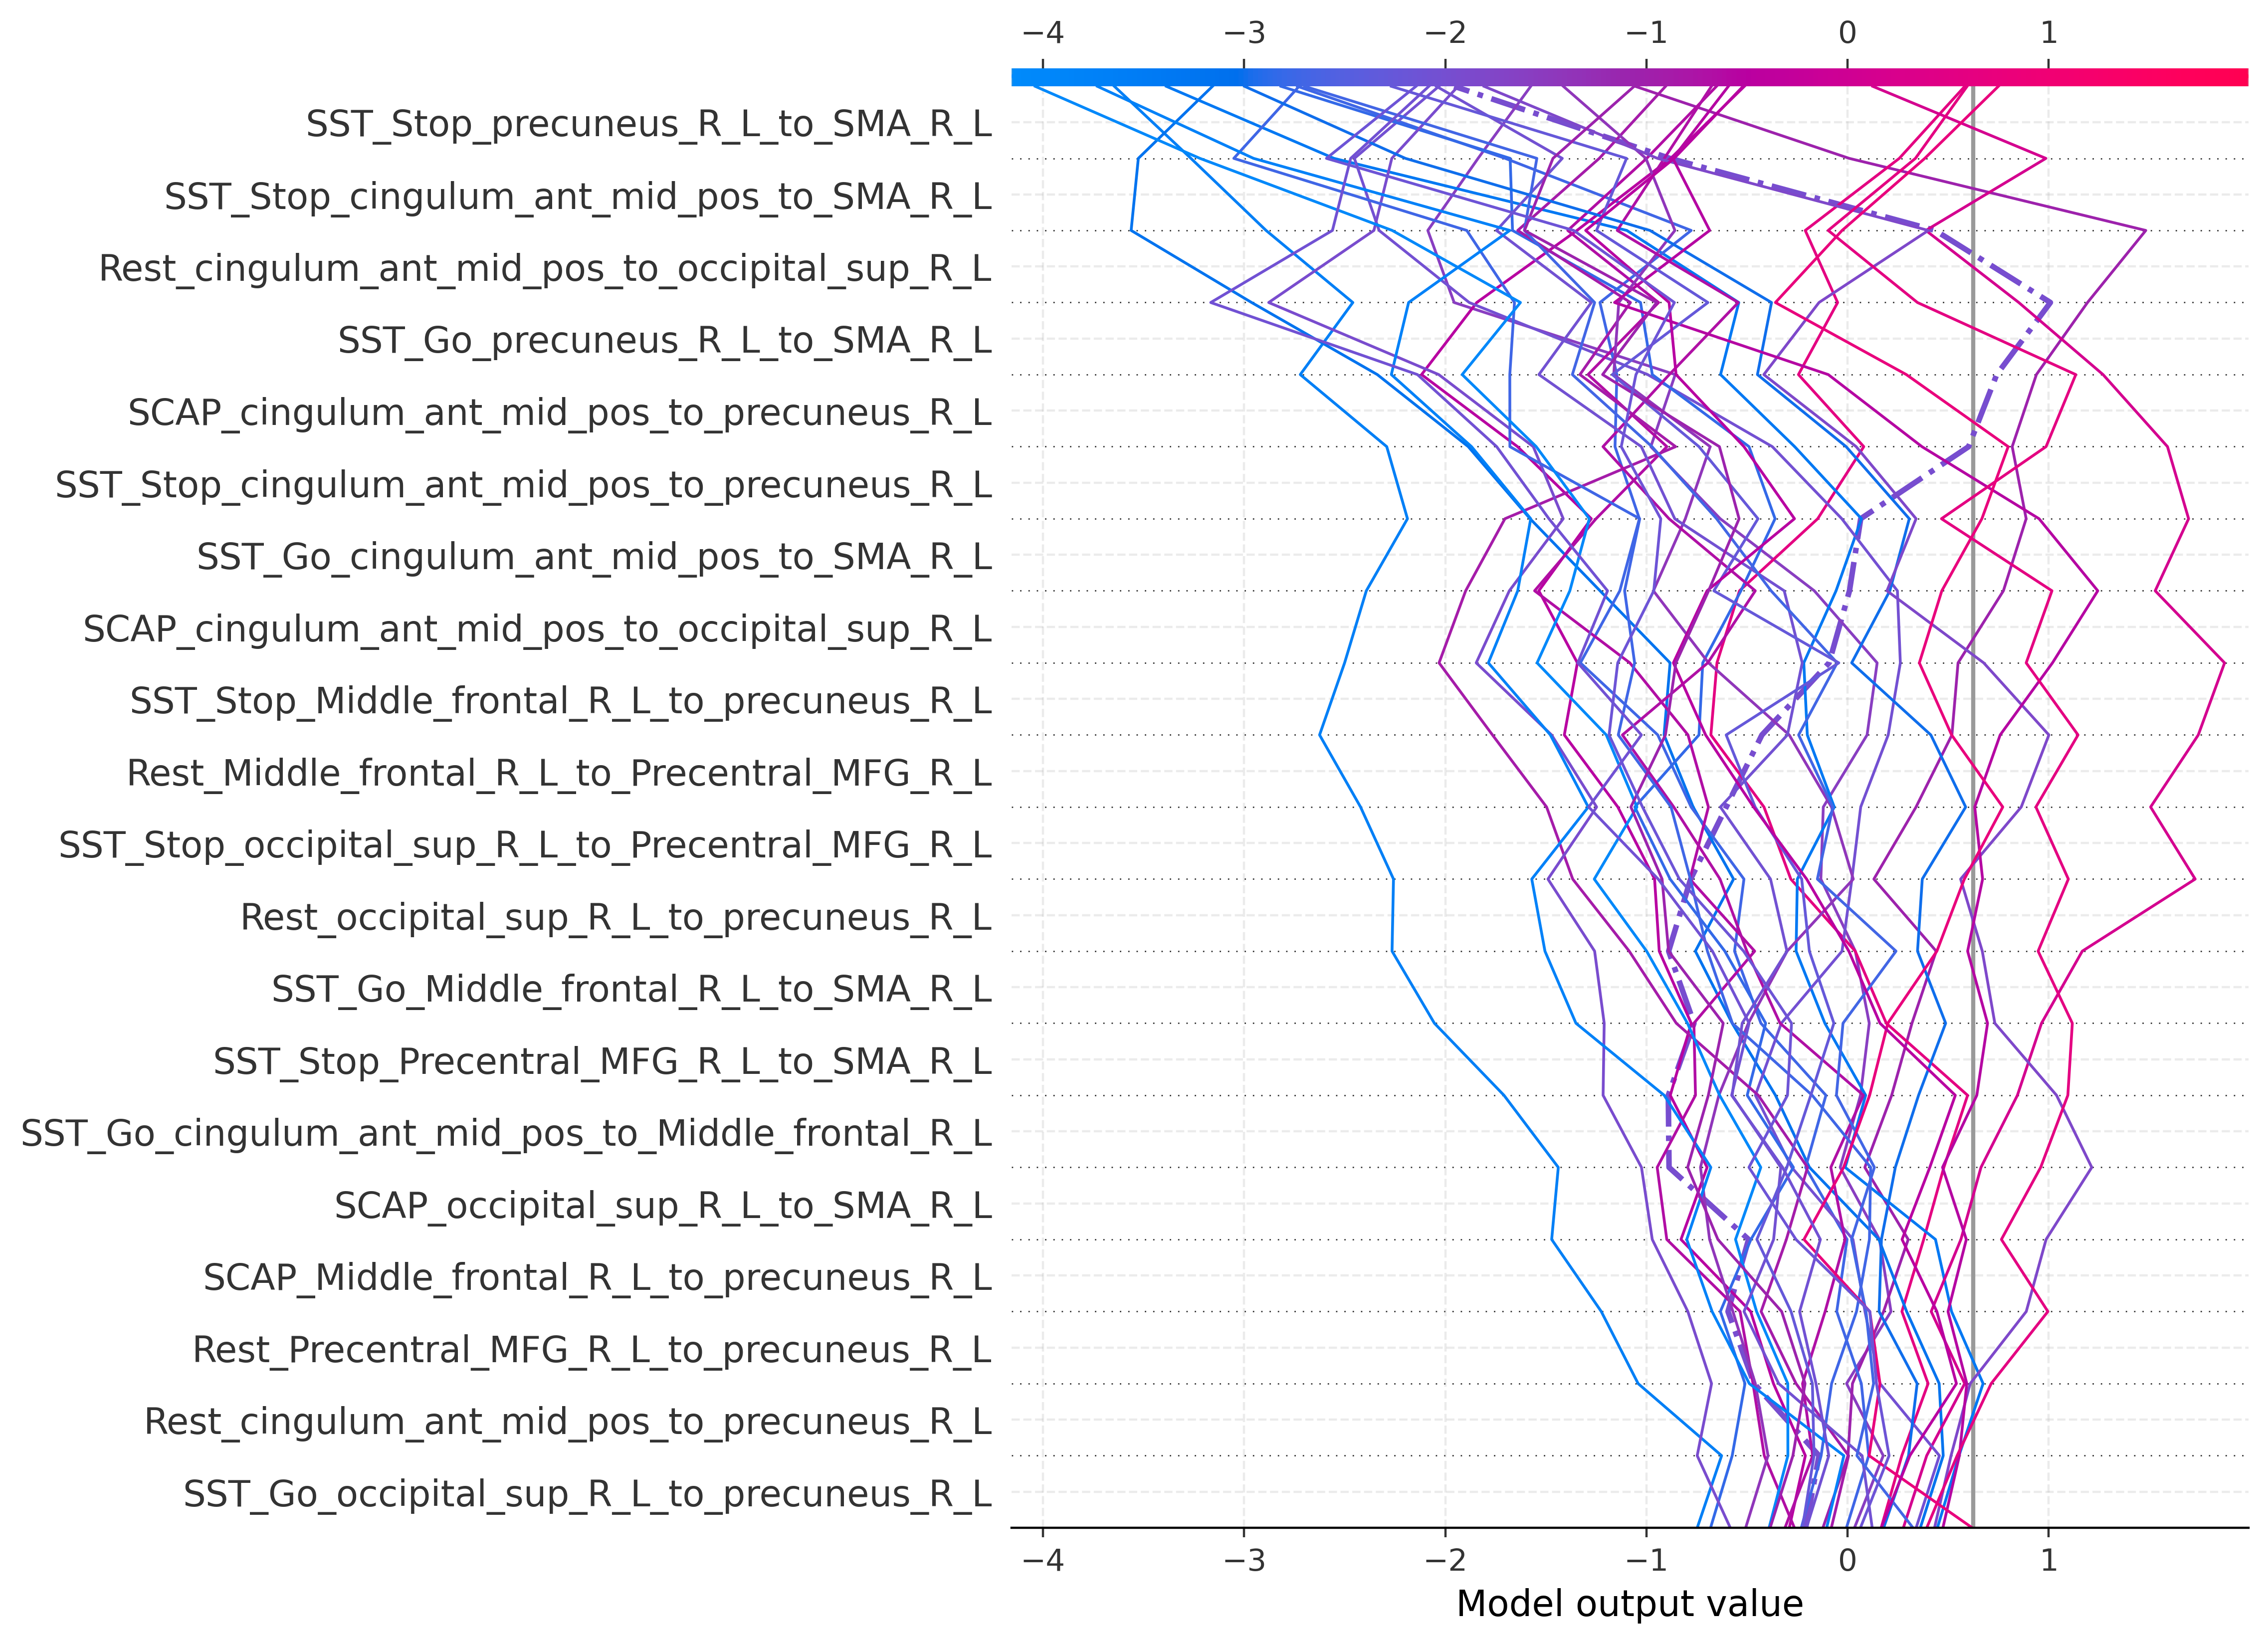

In [10]:
fig = plt.figure(figsize=(10,6))
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values,
    features=X_test,
    feature_names=feature_names,
    highlight=0  # highlight first sample
)
plt.title("SHAP Decision Plot — Model Output Pathways")
savefig_multi(fig, os.path.join(FIGDIR, "shap_decision_global_xgb"))
plt.close(fig)

## 🧭 3️⃣ SHAP **Force Plot (Local Explanation per Subject)**

**Purpose:**

An interactive or static visualization showing how each feature pushes a single sample’s prediction up or down.

**Use case:** Perfect for clinical interpretability — shows patient-level decision explanation.

In [11]:
# Example for a single subject (same i as your waterfall)
i = int(np.where(y_test==1)[0][0]) if np.any(y_test==1) else 0
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values.values[i, :],
    X_test.iloc[i, :],
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot — Sample {i}")
savefig_multi(plt.gcf(), os.path.join(FIGDIR, f"shap_force_xgb_{i:03d}"))
plt.close()


## 🧭 4️⃣ SHAP **Cluster Summary (Dependence clustering)**

**Purpose:**

Groups features with similar SHAP behavior. Helpful when you have correlated features (common in brain connectivity).

**Use case:** Detect redundant or co-active feature groups → supports dimensionality reduction discussion.


In [22]:


fig = plt.figure(figsize=(10,6))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Global Feature Importance — XGBoost")
savefig_multi(fig, os.path.join(FIGDIR, "shap_bar_xgb"))
plt.close(fig)


## 🧭 5️⃣ SHAP **Violin by Class (Custom Grouped Density)**

**Purpose:**

Compare SHAP distributions for each feature between classes (e.g., Control vs ADHD).

**Use case:**
Highlights class-specific contribution patterns — helps explain biological or behavioral asymmetries.

In [13]:
import seaborn as sns
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
shap_df['Label'] = y_test

top_features = np.argsort(np.abs(shap_values.values).mean(0))[::-1][:5]
for f_idx in top_features:
    f_name = feature_names[f_idx]
    fig, ax = plt.subplots(figsize=(6.5,5))
    sns.violinplot(x="Label", y=f_name, data=shap_df, palette="Set2", cut=0)
    ax.set_title(f"SHAP Value Distribution by Class — {f_name}")
    ax.set_xlabel("Label (0=Control, 1=ADHD)")
    ax.set_ylabel("SHAP Value")
    savefig_multi(fig, os.path.join(FIGDIR, f"shap_violin_byclass_{f_name.replace(' ','_')}"))
    plt.close(fig)

C:\Users\Saye\AppData\Local\Temp\ipykernel_10188\955654436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y=f_name, data=shap_df, palette="Set2", cut=0)
C:\Users\Saye\AppData\Local\Temp\ipykernel_10188\955654436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y=f_name, data=shap_df, palette="Set2", cut=0)
C:\Users\Saye\AppData\Local\Temp\ipykernel_10188\955654436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y=f_name, data=shap_df, palette="Set2", cut=0)
C:\Users\Saye\AppData\Local\Tem



## ✅ 

| Plot Type           | Purpose                     | Publication Use              |           |                  |
| ------------------- | --------------------------- | ---------------------------- | --------- | ---------------- |
| **Bar**             | Global mean(                | SHAP                         | ) ranking | Required summary |
| **Beeswarm**        | Distribution per feature    | Standard figure              |           |                  |
| **Violin**          | Density per feature         | Alternative to beeswarm      |           |                  |
| **Dependence**      | Feature interaction         | Core for interpretability    |           |                  |
| **Waterfall**       | Local single subject        | Clinical explanation         |           |                  |
| **Heatmap**         | Sample-level overview       | Group pattern visualization  |           |                  |
| **Decision plot**   | Global reasoning path       | Excellent figure for methods |           |                  |
| **Force plot**      | Per-subject explanation     | Optional but intuitive       |           |                  |
| **Cluster summary** | Correlated feature groups   | Supplementary figure         |           |                  |
| **Violin-by-class** | Classwise SHAP distribution | Good for Results section     |           |                  |

---




# Save the XGBoost Model

In [14]:
# ===================== Save Final XGBoost Model (New File) =====================
import os, json, joblib, datetime, platform
import sklearn, xgboost as xgb

# --- Base folder ---
BASE_DIR = "./xgb_saved_models"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_DIR = os.path.join(BASE_DIR, f"xgb_model_{timestamp}")
os.makedirs(MODEL_DIR, exist_ok=True)

# --- 1) Save the full pipeline (recommended for deployment) ---
final_model = grid_p.best_estimator_  # Full sklearn Pipeline
pipeline_path = os.path.join(MODEL_DIR, "xgb_pipeline.joblib")
joblib.dump(final_model, pipeline_path)

# --- 2) Save only the underlying XGBoost booster (for direct use in XGBoost API) ---
booster = final_model.named_steps["xgb"].get_booster()
booster_path_json = os.path.join(MODEL_DIR, "xgb_booster.json")
booster.save_model(booster_path_json)

# Optional: binary format (smaller, faster to load in C++)
booster_path_bin = os.path.join(MODEL_DIR, "xgb_booster.ubj")
booster.save_model(booster_path_bin)

# --- 3) Save feature names and metadata ---
meta = {
    "model_saved_at": datetime.datetime.utcnow().isoformat() + "Z",
    "model_type": "XGBoost (Pipeline)",
    "best_params": grid_p.best_params_,
    "refit_metric": grid_p.refit,
    "n_features": X.shape[1],
    "feature_names": list(X.columns),
    "python_version": platform.python_version(),
    "sklearn_version": sklearn.__version__,
    "xgboost_version": xgb.__version__,
}

with open(os.path.join(MODEL_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Model and metadata saved successfully!")
print(f"📂 Directory: {MODEL_DIR}")
print("Contents:")
for file in os.listdir(MODEL_DIR):
    print(" -", file)


✅ Model and metadata saved successfully!
📂 Directory: ./xgb_saved_models\xgb_model_20251024_182304
Contents:
 - metadata.json
 - xgb_booster.json
 - xgb_booster.ubj
 - xgb_pipeline.joblib


C:\Users\Saye\AppData\Local\Temp\ipykernel_10188\3490092906.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "model_saved_at": datetime.datetime.utcnow().isoformat() + "Z",


# To Load the Model Later

In [15]:
''' import joblib, pandas as pd, json

MODEL_DIR = "./xgb_saved_models/xgb_model_20251024_153022"  # change to your timestamp folder

# Load pipeline
model = joblib.load(f"{MODEL_DIR}/xgb_pipeline.joblib")

# Load feature names
with open(f"{MODEL_DIR}/metadata.json", "r", encoding="utf-8") as f:
    meta = json.load(f)
feature_names = meta["feature_names"]

# Predict on new data
# X_new must be a DataFrame with the same columns
# y_pred = model.predict(X_new[feature_names])
# y_prob = model.predict_proba(X_new[feature_names])[:, 1]
'''

' import joblib, pandas as pd, json\n\nMODEL_DIR = "./xgb_saved_models/xgb_model_20251024_153022"  # change to your timestamp folder\n\n# Load pipeline\nmodel = joblib.load(f"{MODEL_DIR}/xgb_pipeline.joblib")\n\n# Load feature names\nwith open(f"{MODEL_DIR}/metadata.json", "r", encoding="utf-8") as f:\n    meta = json.load(f)\nfeature_names = meta["feature_names"]\n\n# Predict on new data\n# X_new must be a DataFrame with the same columns\n# y_pred = model.predict(X_new[feature_names])\n# y_prob = model.predict_proba(X_new[feature_names])[:, 1]\n'

# LDA

In [23]:
# ============================================================
# LDA + RFECV (outside pipeline) — 10-fold CV w/ 95% CI
# Unified publication theme + Auto export (PNG, PDF, SVG)
# No SHAP (as requested) | Fixed: RFECV uses f1_macro; CV uses macro metrics
# ============================================================

# ------------------- Imports -------------------
import os, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 1) Unified publication theme + helpers (reuse if already defined)
# ============================================================
try:
    PALETTE
except NameError:
    PALETTE = {
        "roc":     "#1f77b4",  # blue
        "pr":      "#7f3c8d",  # purple
        "bars":    "#1f77b4",  # bars for importance
        "bars_alt":"#ff7f0e",  # negative sign bars
        "diag":    "#8c8c8c",  # diagonal ref line
        "cm":      "Blues",    # confusion matrix cmap
    }

def set_publication_theme(font_family="DejaVu Sans", base=12, grid=True):
    mpl.rcParams.update({
        "figure.dpi": 400, "savefig.dpi": 400,
        "font.size": base, "font.family": font_family,
        "axes.titlesize": base+3, "axes.labelsize": base+1,
        "xtick.labelsize": base-1, "ytick.labelsize": base-1,
        "legend.fontsize": base-1, "figure.titlesize": base+5,
        "axes.grid": grid, "grid.alpha": 0.25, "grid.linestyle": "--",
        "axes.spines.top": False, "axes.spines.right": False,
    })

def title(plot_name: str, model_name: str, suffix: str = "on Selected Features"):
    return f"{plot_name} — {model_name} {suffix}".strip()

def savefig_multi(fig, basepath: str, tight=True):
    if tight: fig.tight_layout()
    fig.savefig(basepath + ".png")
    fig.savefig(basepath + ".pdf")
    fig.savefig(basepath + ".svg")

def ci95(scores):
    scores = np.asarray(scores, dtype=float)
    return 1.96 * scores.std(ddof=1) / np.sqrt(len(scores))

set_publication_theme()  # apply unified style

# ------------------- Output folders -------------------
OUTDIR = "./lda_pub_results"
FIGDIR = os.path.join(OUTDIR, "figs")
os.makedirs(FIGDIR, exist_ok=True)

# ============================================================
# 2) Data
# ============================================================
X = df_combined.drop(columns=["Subject_ID", "Label"]).copy()
y = df_combined["Label"].astype(int)
feature_names_full = X.columns.tolist()
subject_ids = df_combined["Subject_ID"]

# Train/Test split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.20, stratify=y, random_state=42
)

# ============================================================
# 3) RFECV (outside pipeline) — NOW aligned to f1_macro
# ============================================================
rf_selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring="accuracy",           # <-- changed from 'accuracy' to align with imbalance objective
    n_jobs=-1
)
rf_selector.fit(X_train, y_train)

selected_features = X_train.columns[rf_selector.support_]
print(f"\n🔍 Features selected by RFECV ({len(selected_features)}):")
print(selected_features.tolist())

# Filter data to selected features
X_train_sel = X_train[selected_features].copy()
X_test_sel  = X_test[selected_features].copy()
X_full_sel  = X[selected_features].copy()

# ============================================================
# 4) LDA pipeline + GridSearchCV (refit = 'f1_macro')
# ============================================================
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LDA(priors=[0.755, 0.245]))   # fixed priors as you used
])

param_grid = [
    {"lda__solver": ["svd"]},
    {"lda__solver": ["lsqr", "eigen"], "lda__shrinkage": ["auto", None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]},
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",   # EXACT model-selection objective
    n_jobs=-1,
    refit=True,
    verbose=2,
    return_train_score=True
)
grid_search.fit(X_train_sel, y_train)
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# ============================================================
# 5) Train/Test performance
# ============================================================
y_tr_pred  = best_model.predict(X_train_sel)
y_te_pred  = best_model.predict(X_test_sel)
y_tr_prob  = best_model.predict_proba(X_train_sel)[:, 1]
y_te_prob  = best_model.predict_proba(X_test_sel)[:, 1]

print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_tr_pred, target_names=["Control","ADHD"], zero_division=0))

print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_te_pred, target_names=["Control","ADHD"], zero_division=0))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_te_pred):.3f}")

# ============================================================
# 6) 10-fold CV (full X,y) with 95% CI — saved to CSV
#     NOTE: macro metrics to match f1_macro objective
# ============================================================
print("10-fold CV (full X,y) with 95% CI")
scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro",'roc_auc']  # <-- macro metrics
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring, n_jobs=-1)

summary = []
for metric in scoring:
    vals = cv_results[f"test_{metric}"]
    mean = np.mean(vals); ci = ci95(vals)
    summary.append([metric, mean, mean-ci, mean+ci])
    print(f"{metric:<15}: Mean = {mean:.3f}, 95% CI = [{(mean-ci):.3f}, {(mean+ci):.3f}]")
cv_df = pd.DataFrame(summary, columns=["metric","mean","ci_low","ci_high"])
cv_df.to_csv(os.path.join(OUTDIR, "cv_10fold_mean_ci.csv"), index=False)

# ============================================================
# 7) Publication-quality figures (PNG + PDF + SVG)
# ============================================================

# Confusion Matrix — Train
fig = plt.figure(figsize=(6.0,5.0))
ConfusionMatrixDisplay.from_predictions(
    y_train, y_tr_pred, display_labels=["Control","ADHD"], cmap=PALETTE["cm"], ax=plt.gca()
)
plt.title(title("Confusion Matrix", "LDA", suffix="(Train)"))
savefig_multi(fig, os.path.join(FIGDIR, "cm_train_lda")); plt.close(fig)

# Confusion Matrix — Test
fig = plt.figure(figsize=(6.0,5.0))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_te_pred, display_labels=["Control","ADHD"], cmap=PALETTE["cm"], ax=plt.gca()
)
plt.title(title("Confusion Matrix", "LDA", suffix="(Test)"))
savefig_multi(fig, os.path.join(FIGDIR, "cm_test_lda")); plt.close(fig)

# ROC — Test
fpr, tpr, _ = roc_curve(y_test, y_te_prob)
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(7.2,5.2))
plt.plot(fpr, tpr, lw=2, color=PALETTE["roc"], label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], ls="--", color=PALETTE["diag"], lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(title("ROC Curve", "LDA"))
plt.legend(loc="lower right")
savefig_multi(fig, os.path.join(FIGDIR, "roc_test_lda")); plt.close(fig)

# Precision–Recall — Test
precision, recall, _ = precision_recall_curve(y_test, y_te_prob)
pr_auc = average_precision_score(y_test, y_te_prob)
fig = plt.figure(figsize=(7.2,5.2))
plt.plot(recall, precision, lw=2, color=PALETTE["pr"], label=f"PR (AP = {pr_auc:.2f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(title("Precision–Recall Curve", "LDA"))
plt.legend(loc="lower left")
savefig_multi(fig, os.path.join(FIGDIR, "pr_test_lda")); plt.close(fig)

# LDA Coefficient Importance (|coef|) with sign color and labels
lda_model = best_model.named_steps["lda"]
coef = lda_model.coef_.ravel()
imp  = np.abs(coef)

coef_df = (pd.DataFrame({
    "Feature": list(selected_features),
    "Coefficient": coef,
    "Importance": imp,
    "Sign": np.where(coef >= 0, "Positive", "Negative")
})
 .sort_values("Importance", ascending=True))

# Enforce a small visible sliver for zeros (visual only)
eps = max(1e-4, coef_df["Importance"].max() * 1e-3)
plot_vals = np.maximum(coef_df["Importance"].values, eps)

fig = plt.figure(figsize=(11.5, 7.5))
colors = [PALETTE["bars"] if s=="Positive" else PALETTE["bars_alt"] for s in coef_df["Sign"]]
bars = plt.barh(coef_df["Feature"], plot_vals, color=colors)
plt.xlabel("Absolute Coefficient (Importance)")
plt.title("Feature Importance Based on LDA Coefficients")
for b, v in zip(bars, coef_df["Importance"]):
    plt.text(b.get_width() + coef_df["Importance"].max()*0.01,
             b.get_y() + b.get_height()/2, f"{v:.2f}", va="center", fontsize=9)
from matplotlib.patches import Patch
plt.legend([Patch(color=PALETTE["bars"]), Patch(color=PALETTE["bars_alt"])],
           ["Positive","Negative"], title="Coefficient Sign", loc="upper right")
savefig_multi(fig, os.path.join(FIGDIR, "lda_coeff_importance_all")); plt.close(fig)


print("\n✅ LDA analysis complete.")
print("Figures →", FIGDIR)
print("CV CSV  →", os.path.join(OUTDIR, "cv_10fold_mean_ci.csv"))



🔍 Features selected by RFECV (9):
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L']
Fitting 10 folds for each of 19 candidates, totalling 190 fits

✅ Best Parameters: {'lda__solver': 'svd'}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.85      0.98      0.91        96
        ADHD       0.88      0.45      0.60        31

    accuracy                           0.85       127
   macro avg       0.86      0.72      0.75       127
weighted avg       0.85      0.85      0.83       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Con

# LDA: Bootstrapped CIs + Shaded ROC/PR Bands

In [17]:
# ========= LDA: Bootstrapped AUC/AP 95% CIs + Shaded ROC/PR Bands =========
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

rng = np.random.default_rng(42)

def stratified_boot_indices(y, rng):
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    b_pos = rng.choice(idx_pos, size=idx_pos.size, replace=True)
    b_neg = rng.choice(idx_neg, size=idx_neg.size, replace=True)
    return np.concatenate([b_pos, b_neg])

def bootstrap_auc_ci(y_true, y_prob, metric_fn, n_boot=2000):
    y = np.asarray(y_true)      # <-- convert to numpy
    p = np.asarray(y_prob)
    vals = []
    for _ in range(n_boot):
        bidx = stratified_boot_indices(y, rng)
        vals.append(metric_fn(y[bidx], p[bidx]))
    vals = np.asarray(vals)
    return vals.mean(), np.percentile(vals, 2.5), np.percentile(vals, 97.5)

def bootstrap_curve_ci(y_true, y_prob, curve_fn, x_grid):
    y = np.asarray(y_true)
    p = np.asarray(y_prob)
    curves = []
    for _ in range(2000):
        bidx = stratified_boot_indices(y, rng)
        x, yv, _ = curve_fn(y[bidx], p[bidx])
        curves.append(np.interp(x_grid, x, yv))
    curves = np.vstack(curves)
    return curves.mean(0), np.percentile(curves, 2.5, axis=0), np.percentile(curves, 97.5, axis=0)

# Pull test arrays produced by your previous LDA cell
y_true = y_test.values if hasattr(y_test, "values") else y_test
y_prob = y_te_prob

# Scalar CIs
roc_mean, roc_lo, roc_hi = bootstrap_auc_ci(y_true, y_prob, roc_auc_score)
pr_mean,  pr_lo,  pr_hi  = bootstrap_auc_ci(y_true, y_prob, average_precision_score)
print(f"LDA — ROC AUC (boot) = {roc_mean:.3f} [95% CI {roc_lo:.3f}–{roc_hi:.3f}]")
print(f"LDA — PR  AUC (boot) = {pr_mean:.3f} [95% CI {pr_lo:.3f}–{pr_hi:.3f}]")

# Curves + shaded bands
# --- ROC ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
grid = np.linspace(0, 1, 200)
mu, lo, hi = bootstrap_curve_ci(y_true, y_prob, roc_curve, grid)

fig = plt.figure(figsize=(7.2, 5.2))
plt.plot(fpr, tpr, lw=2, color=PALETTE["roc"], label=f"ROC (AUC={roc_mean:.2f})")
plt.fill_between(grid, lo, hi, color=PALETTE["roc"], alpha=0.15, label="95% CI")
plt.plot([0,1],[0,1], ls="--", color=PALETTE["diag"], lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(title("ROC Curve", "LDA"))
plt.legend(loc="lower right")
savefig_multi(fig, os.path.join(FIGDIR, "roc_test_lda_CI")); plt.close(fig)

# --- PR ---
prec, rec, _ = precision_recall_curve(y_true, y_prob)
grid = np.linspace(0, 1, 200)
# note: PR is parameterized as recall(x), precision(y)
def _pr_curve(y, p):
    R, P, _ = precision_recall_curve(y, p)
    return R, P, None
mu, lo, hi = bootstrap_curve_ci(y_true, y_prob, _pr_curve, grid)

fig = plt.figure(figsize=(7.2, 5.2))
plt.plot(rec, prec, lw=2, color=PALETTE["pr"], label=f"PR (AP={pr_mean:.2f})")
plt.fill_between(grid, lo, hi, color=PALETTE["pr"], alpha=0.15, label="95% CI")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(title("Precision–Recall Curve", "LDA"))
plt.legend(loc="lower left")
savefig_multi(fig, os.path.join(FIGDIR, "pr_test_lda_CI")); plt.close(fig)


LDA — ROC AUC (boot) = 0.663 [95% CI 0.427–0.875]
LDA — PR  AUC (boot) = 0.532 [95% CI 0.272–0.796]


# Save the LDA model bundle

In [18]:
# ============================================================
# 💾 SAVE LDA MODEL BUNDLE — in a new dedicated folder
# ============================================================
import os, time, json, joblib, platform, sklearn
from datetime import datetime

# Create a new root folder separate from OUTDIR
LDA_MODEL_ROOT = "./lda_saved_models"
os.makedirs(LDA_MODEL_ROOT, exist_ok=True)

# Create a timestamped subfolder for this specific run
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
SAVE_DIR = os.path.join(LDA_MODEL_ROOT, f"LDA_RFECV_{stamp}")
os.makedirs(SAVE_DIR, exist_ok=True)

# Define file paths
MODEL_PATH = os.path.join(SAVE_DIR, "lda_model_bundle.joblib")
META_PATH  = os.path.join(SAVE_DIR, "lda_model_metadata.json")

# Bundle everything needed for reproducibility
bundle = {
    "pipeline": best_model,                        # fitted pipeline (scaler + LDA)
    "selected_features": list(selected_features),  # exact feature set
    "best_params": getattr(grid_search, "best_params_", None),
    "priors": getattr(best_model.named_steps["lda"], "priors_", None),
    "cv_folds": getattr(grid_search.cv, "n_splits", None),
    "label_name": "Label",
    "created_utc": datetime.utcnow().isoformat() + "Z",
    "versions": {
        "python": platform.python_version(),
        "sklearn": sklearn.__version__,
    },
    "notes": "LDA + RFECV (outside pipeline), refit=f1_macro, 10-fold CV",
}

# Save the bundle and metadata
joblib.dump(bundle, MODEL_PATH)
meta = {
    "model_file": os.path.basename(MODEL_PATH),
    "created_utc": bundle["created_utc"],
    "n_features": len(bundle["selected_features"]),
    "best_params": bundle["best_params"],
    "versions": bundle["versions"],
}
with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print(f"✅ LDA model saved to: {MODEL_PATH}")
print(f"📝 Metadata file saved to: {META_PATH}")


✅ LDA model saved to: ./lda_saved_models\LDA_RFECV_20251024_182530\lda_model_bundle.joblib
📝 Metadata file saved to: ./lda_saved_models\LDA_RFECV_20251024_182530\lda_model_metadata.json


C:\Users\Saye\AppData\Local\Temp\ipykernel_10188\4080820528.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.utcnow().isoformat() + "Z",


# Load and use the saved model later

In [19]:
'''# ============================================================
# 📦 LOAD & USE SAVED LDA MODEL BUNDLE
# ============================================================
import os, json, joblib
import numpy as np
import pandas as pd

# Set folder of a saved model (paste from print output if needed)
LOAD_DIR = SAVE_DIR  # e.g., "./lda_saved_models/LDA_RFECV_20251024_193812"
MODEL_PATH = os.path.join(LOAD_DIR, "lda_model_bundle.joblib")
META_PATH  = os.path.join(LOAD_DIR, "lda_model_metadata.json")

# Load bundle and metadata
bundle = joblib.load(MODEL_PATH)
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

lda_pipeline = bundle["pipeline"]
selected_features = bundle["selected_features"]

print(f"🔁 Loaded LDA pipeline with {len(selected_features)} features.")
print("📜 Model versions:", bundle["versions"])
print("🧩 Best parameters:", bundle["best_params"])

# ----- Prepare data for prediction -----
# Example: use df_combined again or any new dataset with same features
df_new = df_combined.copy()

# Reindex to match feature order and fill missing columns with 0
X_new = df_new.reindex(columns=selected_features)
missing = [c for c in selected_features if c not in df_new.columns]
if missing:
    print(f"⚠️ Missing columns filled with 0: {missing[:5]}{' ...' if len(missing)>5 else ''}")
X_new = X_new.fillna(0.0)

# ----- Predict -----
y_pred = lda_pipeline.predict(X_new)
y_prob = lda_pipeline.predict_proba(X_new)[:, 1]

# Attach predictions to dataframe
df_pred = df_new.copy()
df_pred["pred_label"] = y_pred
df_pred["pred_proba"] = y_prob

print("✅ Predictions complete.")
print("🔢 Shape:", df_pred.shape)
df_pred.head()
'''

'# ============================================================\n# 📦 LOAD & USE SAVED LDA MODEL BUNDLE\n# ============================================================\nimport os, json, joblib\nimport numpy as np\nimport pandas as pd\n\n# Set folder of a saved model (paste from print output if needed)\nLOAD_DIR = SAVE_DIR  # e.g., "./lda_saved_models/LDA_RFECV_20251024_193812"\nMODEL_PATH = os.path.join(LOAD_DIR, "lda_model_bundle.joblib")\nMETA_PATH  = os.path.join(LOAD_DIR, "lda_model_metadata.json")\n\n# Load bundle and metadata\nbundle = joblib.load(MODEL_PATH)\nwith open(META_PATH, "r", encoding="utf-8") as f:\n    meta = json.load(f)\n\nlda_pipeline = bundle["pipeline"]\nselected_features = bundle["selected_features"]\n\nprint(f"🔁 Loaded LDA pipeline with {len(selected_features)} features.")\nprint("📜 Model versions:", bundle["versions"])\nprint("🧩 Best parameters:", bundle["best_params"])\n\n# ----- Prepare data for prediction -----\n# Example: use df_combined again or any new da